In [29]:
# Install necessary packages 
!pip install --upgrade torch-scatter
!pip install --upgrade torch-sparse
!pip install --upgrade torch-cluster
!pip install --upgrade torch-spline-conv 
!pip install torch-geometric

In [1]:
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
# Load the dataset
dataset = 'Photo'
root = '/tmp/Amazon'
dataset = Amazon(root, dataset, transform=T.TargetIndegree())
data = dataset[0]

In [23]:
# Explore the data
print(data, end="\n\n")
print(f"Dataset classes: {dataset.num_classes}")
print(f"Labels range: [{int(min(data.y))}, {int(max(data.y))}]")
print(f"Labels: {data.y}\n")
print(f"Number of Nodes: {data.num_nodes}")
print(f"Features per Node: {dataset.num_node_features}")
print(f"Node Features: {data.x}\n")
print(f"Number of edges: {data.num_edges}")
print(f"Features per edge: {data.num_edge_features}")
print(f"Edge indices: {data.edge_index}")
print(f"Edge attributes: {data.edge_attr}")

Data(x=[7650, 745], edge_index=[2, 238162], y=[7650], edge_attr=[238162, 1])

Dataset classes: 8
Labels range: [0, 7]
Labels: tensor([6, 4, 3,  ..., 1, 2, 3])

Number of Nodes: 7650
Features per Node: 745
Node Features: tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Number of edges: 238162
Features per edge: 1
Edge indices: tensor([[   0,    0,    0,  ..., 7649, 7649, 7649],
        [1210, 2198, 2239,  ..., 2239, 3295, 4196]])
Edge attributes: tensor([[0.1771],
        [1.0000],
        [0.6953],
        ...,
        [0.6953],
        [0.0628],
        [0.0132]])


In [24]:
import numpy as np

def edge_index_to_adj_matrix(edge_index, num_nodes):
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i, j in edge_index.T.tolist():
        adj_matrix[i][j] = 1
        adj_matrix[j][i] = 1  # For undirected graphs
    return adj_matrix

# Example usage with PyTorch Geometric data
import torch
from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T

# Load the dataset
dataset = 'Photo'
root = '/tmp/Amazon'
dataset = Amazon(root, dataset, transform=T.TargetIndegree())
data = dataset[0]

# Create adjacency matrix
adj_matrix = edge_index_to_adj_matrix(data.edge_index.cpu().numpy(), data.num_nodes)
print("Adjacency Matrix:")
print(adj_matrix)


Adjacency Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [25]:
import numpy as np

def edge_index_to_adj_list(edge_index):
    adj_list = {}
    for i, j in edge_index.T.tolist():
        if i not in adj_list:
            adj_list[i] = []
        if j not in adj_list:
            adj_list[j] = []
        adj_list[i].append(j)
        adj_list[j].append(i)  # For undirected graphs
    return adj_list

# Example usage with PyTorch Geometric data
import torch
from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T

# Load the dataset
dataset = 'Photo'
root = '/tmp/Amazon'
dataset = Amazon(root, dataset, transform=T.TargetIndegree())
data = dataset[0]

# Create adjacency list
adj_list = edge_index_to_adj_list(data.edge_index.cpu().numpy())
print("Adjacency List:")
for node, neighbors in adj_list.items():
    print(f"Node {node}: {neighbors}")


Adjacency List:
Node 0: [1210, 2198, 2239, 3152, 3578, 4337, 4771, 5167, 5372, 7395, 1210, 2198, 2239, 3152, 3578, 4337, 4771, 5167, 5372, 7395]
Node 1210: [0, 14, 69, 77, 85, 98, 124, 138, 192, 240, 260, 290, 320, 322, 369, 415, 421, 473, 540, 593, 687, 693, 727, 795, 813, 831, 841, 951, 1018, 1058, 1097, 1152, 1169, 1178, 1206, 0, 14, 69, 77, 85, 98, 124, 138, 192, 240, 260, 290, 320, 322, 369, 415, 421, 473, 540, 593, 687, 693, 727, 795, 813, 831, 841, 951, 1018, 1058, 1097, 1152, 1169, 1178, 1206, 1211, 1218, 1254, 1268, 1284, 1333, 1357, 1370, 1399, 1414, 1415, 1430, 1431, 1447, 1453, 1485, 1540, 1575, 1581, 1620, 1634, 1665, 1668, 1684, 1711, 1798, 1840, 1862, 1875, 1908, 1965, 1996, 1997, 2039, 2060, 2115, 2120, 2129, 2198, 2229, 2239, 2310, 2334, 2336, 2370, 2410, 2485, 2571, 2573, 2587, 2595, 2645, 2657, 2671, 2730, 2736, 2738, 2745, 2772, 2782, 2801, 2848, 2882, 2904, 2908, 2958, 2981, 3049, 3050, 3070, 3074, 3123, 3160, 3172, 3177, 3183, 3226, 3234, 3245, 3279, 3334, 3362, 3

In [26]:
import numpy as np

def edge_index_to_edge_list(edge_index):
    return edge_index.T.tolist()

# Example usage with PyTorch Geometric data
import torch
from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T

# Load the dataset
dataset = 'Photo'
root = '/tmp/Amazon'
dataset = Amazon(root, dataset, transform=T.TargetIndegree())
data = dataset[0]

# Create edge list
edge_list = edge_index_to_edge_list(data.edge_index.cpu().numpy())
print("Edge List:")
for edge in edge_list:
    print(f"Edge: {edge}")


Edge List:
Edge: [0, 1210]
Edge: [0, 2198]
Edge: [0, 2239]
Edge: [0, 3152]
Edge: [0, 3578]
Edge: [0, 4337]
Edge: [0, 4771]
Edge: [0, 5167]
Edge: [0, 5372]
Edge: [0, 7395]
Edge: [1, 107]
Edge: [1, 483]
Edge: [1, 490]
Edge: [1, 856]
Edge: [1, 1066]
Edge: [1, 1315]
Edge: [1, 2113]
Edge: [1, 2648]
Edge: [1, 3013]
Edge: [1, 4259]
Edge: [1, 4735]
Edge: [1, 5321]
Edge: [1, 5433]
Edge: [1, 6417]
Edge: [1, 6563]
Edge: [1, 7128]
Edge: [1, 7359]
Edge: [2, 1036]
Edge: [2, 2152]
Edge: [2, 3592]
Edge: [2, 3818]
Edge: [2, 4183]
Edge: [2, 4757]
Edge: [2, 6684]
Edge: [2, 7558]
Edge: [2, 7590]
Edge: [3, 260]
Edge: [3, 448]
Edge: [3, 552]
Edge: [3, 1058]
Edge: [3, 1575]
Edge: [3, 2170]
Edge: [3, 2198]
Edge: [3, 2239]
Edge: [3, 2370]
Edge: [3, 3049]
Edge: [3, 3152]
Edge: [3, 3311]
Edge: [3, 3748]
Edge: [3, 4086]
Edge: [3, 4376]
Edge: [3, 4670]
Edge: [3, 4805]
Edge: [3, 5070]
Edge: [3, 5234]
Edge: [3, 5258]
Edge: [3, 5404]
Edge: [3, 5641]
Edge: [3, 6424]
Edge: [3, 6847]
Edge: [3, 6952]
Edge: [3, 7467]
Edge

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
# Feature matrix
print("\nFeature Matrix:")
print(data.x.cpu().numpy())



Feature Matrix:
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [28]:
# Class labels
print("\nClass Labels:")
print(data.y.cpu().numpy())



Class Labels:
[6 4 3 ... 1 2 3]


In [29]:
# Split the training, test, and validation set
train_size, val_size, test_size = 5000, 1000, 1000  # Example sizes
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:train_size] = 1

data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[train_size:train_size + val_size] = 1

data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[train_size + val_size:train_size + val_size + test_size] = 1

In [30]:
# Building the Neural Network with GCN layers
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)  # First GCN layer
        self.conv2 = GCNConv(16, dataset.num_classes)  # Second GCN layer

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))  # Apply ReLU after the first GCN layer
        x = F.dropout(x, training=self.training)  # Apply dropout for regularization
        x = self.conv2(x, edge_index)  # Second GCN layer
        return F.log_softmax(x, dim=1)  # Apply log softmax to get the final output

In [31]:
# Create an instance of the model and define optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


In [32]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [33]:
# Test function
def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [34]:
# Validation function
def validate():
    model.eval()
    logits = model()
    pred = logits[data.val_mask].max(1)[1]
    acc = pred.eq(data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    return acc


In [35]:
# Initialize lists to store training history
history = {'loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}

# Training and evaluation loop
for epoch in range(1, 290):
    loss = train()
    train_acc, val_acc, test_acc = test()
    history['loss'].append(loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)
    
    log = f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}'
    print(log)

Epoch: 001, Loss: 2.2061, Train Acc: 0.2138, Val Acc: 0.2370, Test Acc: 0.2290
Epoch: 002, Loss: 2.0654, Train Acc: 0.2162, Val Acc: 0.2380, Test Acc: 0.2310
Epoch: 003, Loss: 2.0114, Train Acc: 0.2176, Val Acc: 0.2390, Test Acc: 0.2300
Epoch: 004, Loss: 1.9565, Train Acc: 0.2246, Val Acc: 0.2480, Test Acc: 0.2330
Epoch: 005, Loss: 1.9596, Train Acc: 0.2338, Val Acc: 0.2570, Test Acc: 0.2430
Epoch: 006, Loss: 1.9409, Train Acc: 0.2420, Val Acc: 0.2610, Test Acc: 0.2480
Epoch: 007, Loss: 1.9085, Train Acc: 0.2582, Val Acc: 0.2730, Test Acc: 0.2650
Epoch: 008, Loss: 1.8585, Train Acc: 0.3922, Val Acc: 0.4090, Test Acc: 0.4050
Epoch: 009, Loss: 1.8515, Train Acc: 0.4238, Val Acc: 0.4410, Test Acc: 0.4330
Epoch: 010, Loss: 1.8259, Train Acc: 0.4258, Val Acc: 0.4440, Test Acc: 0.4350
Epoch: 011, Loss: 1.7933, Train Acc: 0.4270, Val Acc: 0.4440, Test Acc: 0.4350
Epoch: 012, Loss: 1.7808, Train Acc: 0.4280, Val Acc: 0.4440, Test Acc: 0.4360
Epoch: 013, Loss: 1.7432, Train Acc: 0.4288, Val Acc

In [36]:
# Validate the model on validation data
val_acc = validate()
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.9300


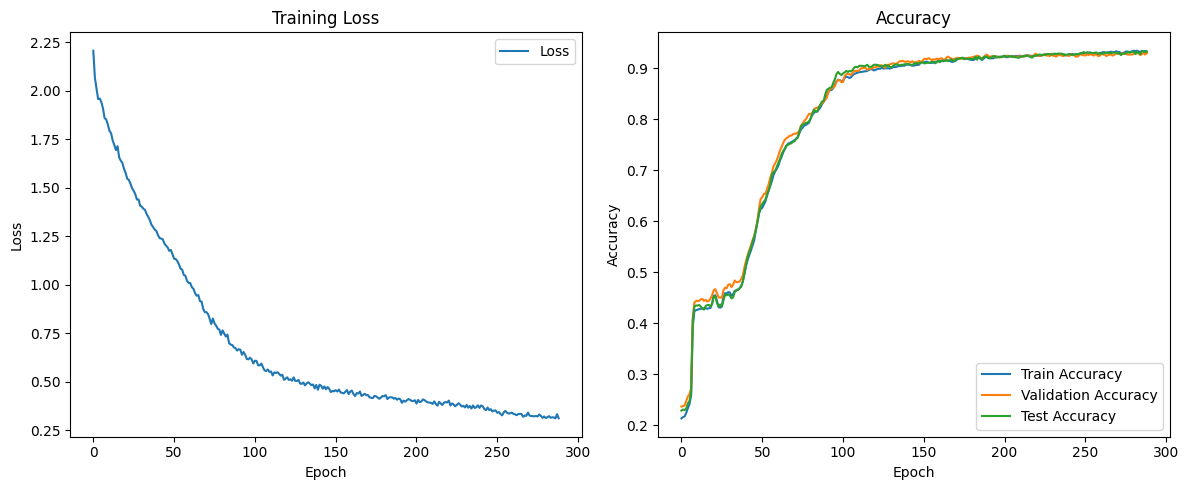

In [37]:
# Plot training history
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [38]:
import numpy as np
# Generate node predictions
model.eval()
with torch.no_grad():
    all_predictions = model().cpu().numpy()  # Get predictions
    node_predictions = np.argmax(all_predictions, axis=1)

In [39]:
# Create a DataFrame with predictions and true labels
df = pd.DataFrame({"Predicted": node_predictions, "True": data.y.cpu().numpy()})
print(df.head(20))

    Predicted  True
0           6     6
1           4     4
2           3     3
3           6     6
4           5     5
5           3     3
6           4     4
7           2     2
8           3     3
9           6     6
10          2     2
11          5     5
12          1     1
13          1     1
14          6     6
15          3     2
16          0     0
17          5     5
18          6     6
19          5     5


In [40]:
# Extract embeddings
embedding_model = Net()
embedding_model.load_state_dict(model.state_dict())
embedding_model.eval()
embeddings = embedding_model.conv1(data.x, data.edge_index).detach().cpu().numpy()

In [41]:
# Dimensionality reduction
transform = TSNE(n_components=2)  # or PCA
X = embeddings
X_reduced = transform.fit_transform(X)


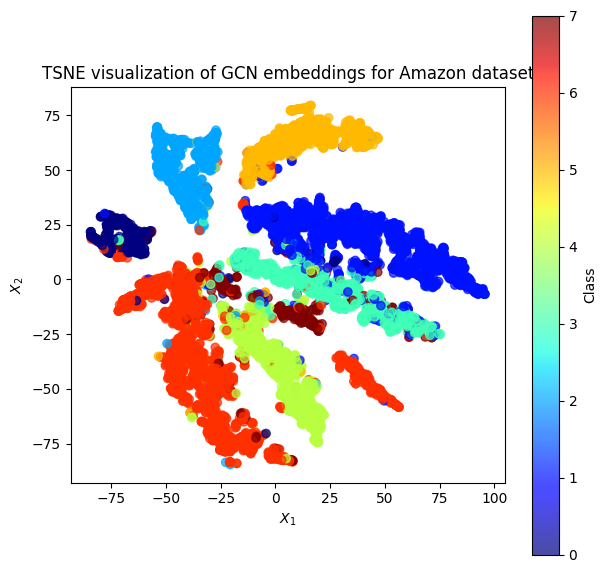

In [42]:
# Plot embeddings
fig, ax = plt.subplots(figsize=(7, 7))
scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=data.y.cpu().numpy(),  # Use node labels for coloring
    cmap="jet",
    alpha=0.7
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__class__.__name__} visualization of GCN embeddings for Amazon dataset"
)
plt.colorbar(scatter, ax=ax, label='Class')
plt.show()